In [1]:
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

import cv2

Using TensorFlow backend.


In [2]:
num_classes = 10
model_name = 'models/50_model.json'
weights_name = 'weights/50_weights.h5'

In [3]:
def predict(x, model):
    pred = model.predict(np.array([x]), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [22]:
def Grad_Cam(model, x, layer_name='conv2d_4'):
    
#     K.set_learning_phase(1)
    
    pred_class, pred_per = predict(x, model)
    class_output = model.output[:, int(pred_class)]
    
    #  勾配を取得
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([np.array([x])])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)


    # 画像化してヒートマップにして合成
    cam = cv2.resize(cam, (32, 32), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0) 
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam)/255.0 + x / 2).clip(min=0, max=1)   # もとの画像に合成

    return jetcam

In [23]:
# データの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train_catego = to_categorical(y_train, num_classes)
y_test_catego = to_categorical(y_test, num_classes)

50000 train samples
10000 test samples


In [24]:
model = model_from_json(open(model_name).read())
model.load_weights(weights_name)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [25]:
# score = model.evaluate(x_test, y_test_catego, verbose=0)
# print('x_test')
# print('Test loss :', score[0])
# print('Test accuracy :', score[1])

In [26]:
label =['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

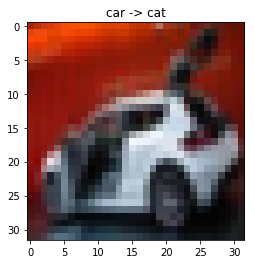

In [27]:
idx = 6
x = x_test[idx].copy()
y = int(y_test[idx])

pred_class, pred_per = predict(x, model)
plt.imshow(x)
plt.title(f'{label[y]} -> {label[pred_class]}')
plt.show()

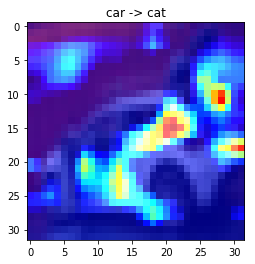

In [28]:
grad_cam = Grad_Cam(model, x) 

plt.imshow(grad_cam)
plt.title(f'{label[y]} -> {label[pred_class]}')
plt.show()

x_test


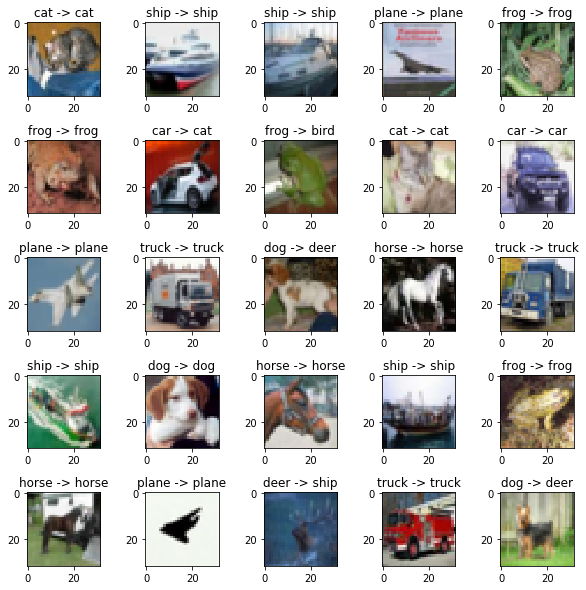

In [29]:
print('x_test')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = x_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

grad_cam


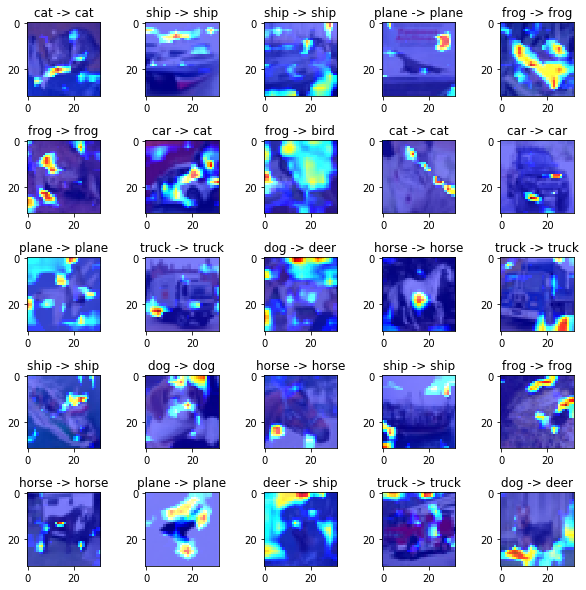

In [30]:
print('grad_cam')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = Grad_Cam(model, x_test[i]) 
    pred_class, pred_per = predict(x_test[i], model)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

In [31]:
adv_test = np.load('npy/advs_test_50_model.npy')

print(adv_test.shape[0], 'adv test samples')

10000 adv test samples


adv_test


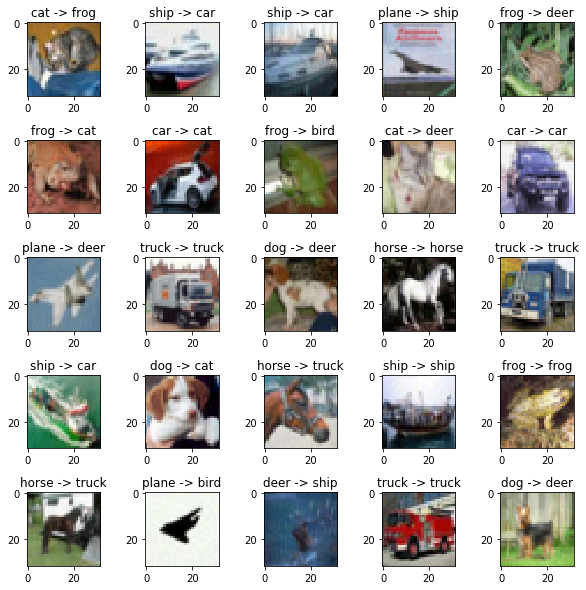

In [32]:
print('adv_test')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = adv_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

grad_cam adv


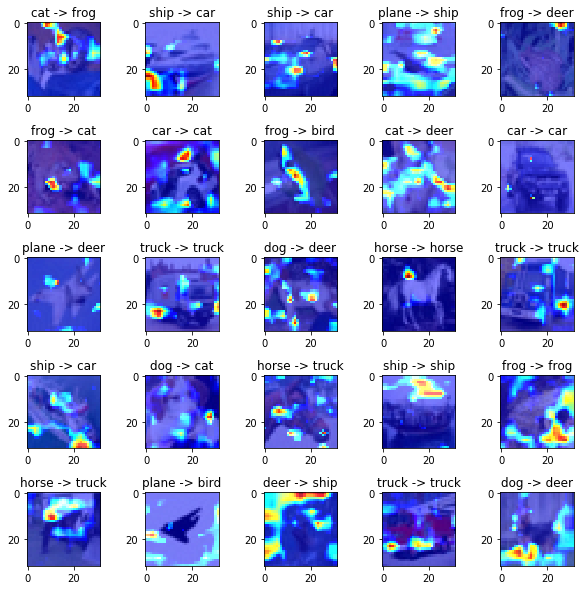

In [33]:
print('grad_cam adv')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = Grad_Cam(model, adv_test[i]) 
    pred_class, pred_per = predict(adv_test[i], model)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()